# Introduction

**Problem Description**: we have a ton of unclassified images containing either a document (scanned or in a photo),
a colour photo or a RX medical image (again scanned or in a photo).

**Goal**: classify all these in the three classes, in order to unload human work.

**Questions to be addressed**

Why is this task so easy for a human eye?
How can we transfer to skill to a computer?
How can we differentiate for example between a RX medical image and a colour photo?
Which are the features that can help differentiate them?
Can we do this job without the use of convolutional neural networks?

**Ready? Let's solve this!**

 
 **1.** First, we create a grid to divide each image into nine squares:

In [1]:
import string

xpix, ypix = 299, 299          # number of x and y pixels into which resizing the original images
white_th, black_th = 235, 20   # threshold to define white and black in grey scale
xsplit, ysplit = 3, 3          # number of splits in x and y direcitons
select = [0,2,4,6,8]           # select squares
suffix = ['_'+i for i in string.ascii_uppercase]  # suffix for features


**2.** Next, We create a list with the names of the test images:

In [2]:
import os
from os import *

fol = r'./test_images'+os.sep  # define path where test images are stored
included_extensions = ['jpg', 'jpeg', 'tif', 'gif']  # extensions of the images
file = [fn for fn in listdir(fol) if any(fn.endswith(ext) for ext in included_extensions)]  # file names


**3.** Let's define a function to load the images, apply the grid and compute the features:
* Feature engineering is done via "feature_eng_dict" function, which can be inspected in the utils.py


In [3]:
from Utilities import *

def par_job_dict(ifil): 
    dict_temp = {}
    
    img = Image.open(fol+ifil)
    img = img.resize((xpix,ypix), PIL.Image.ANTIALIAS)
    img = img.convert('RGB')
    img = np.array(img) 
    
    dict_temp['fn'] = str(ifil)

    dict_func = feature_eng_dict(img, '_TOT')
    dict_temp.update(dict_func)
    
    # divide img in subimg
    height, width, channels = img.shape
    xticks = [round(i*1.0/xsplit*width) for i in range(xsplit)] 
    xticks.append(width)
    yticks = [round(i*1.0/xsplit*height) for i in range(ysplit)] 
    yticks.append(height)
    subimg = list(range(len(select)))

    for isel in range(0,len(select)):
        row = int((select[isel])/xsplit)
        col = (select[isel])%xsplit
        subimg[isel] = img[xticks[row]:xticks[row+1],yticks[col]:yticks[col+1]]

        dict_func = feature_eng_dict(subimg[isel], suffix[isel])

        dict_temp.update(dict_func)

    return dict_temp


**4.** Now we call the previous function in parallel, for computational speed.
* The Parallel function only works in a Linux environment
* Parallel is a easy to use front-end for multiprocessing backend 

In [4]:
from joblib import Parallel, delayed
import PIL
from PIL import Image
import numpy as np
from Utilities import *
np.seterr(divide='ignore', invalid='ignore')

num_cores = 8   # number of cores to use
out = Parallel(n_jobs=num_cores, backend = 'multiprocessing', pre_dispatch = '3*n_jobs', verbose=1, 
                   batch_size = 1, max_nbytes='10G',)(delayed(par_job_dict)(ifil) for ifil in file)

df = pd.DataFrame(out)

[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    0.2s finished


**5.** Create df with predictors

In [5]:
feat = ['ncolor','R_G_diff','R_B_diff','G_B_diff','white_perc','black_perc','gray_perc',
        'h_mean','s_mean','v_mean','c_mean','l_mean','s_l_mean','h_median','s_median',
        'v_median','c_median','l_median','s_l_median','h_var','s_var','v_var','c_var',
        'l_var','s_l_var','distq_RG0','distq_RB0','distq_RG1','distq_RB1','distq_RG2',
        'distq_RB2']

cl = ['_TOT'] + suffix[:len(select)]
X = ['fn']

for el in feat:
    c = [el + x  for x in cl]
    X.extend(c)

df = df[X]

**6.** **Done!** You are ready to predict with our **"xgb_17k_final_prob.model"** model on your own set of similar data

Or you can train it on your very specific data set by providing a response (y) variable

simply train a ex-novo model instead of using the provided one.

## Empirical predictive example

**7.** Let's import our pre-trained model

In [6]:
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore") # ignore deprecation warning

model = xgb.Booster({'nthread':4}) #init model
model.load_model("xgb_17k_final_prob.model") # load mdoel

**8.** let's plot 3 images we want to predict, noting that:
* 0: Color
* 1: RX
* 2: Text

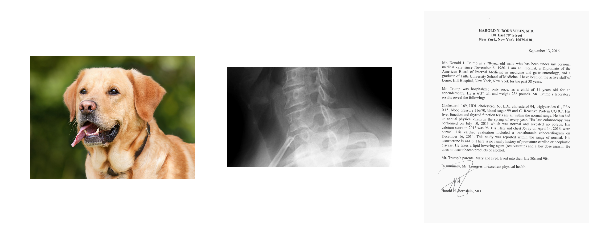

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

dog = Image.open('test_images/dog.jpg')
text = Image.open('test_images/text.gif')
rx = Image.open('test_images/Rx_medical.jpg')

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(dog)
plt.axis('off')

ax1 = fig.add_subplot(1,3,2)
ax1.imshow(rx)
plt.axis('off')

ax1 = fig.add_subplot(1,3,3)
ax1.imshow(text)
plt.axis('off')

plt.show()


**9.** We are now ready to predict and print our output

In [16]:
xg_df = xgb.DMatrix(df.iloc[:,1:].values)
prediction = model.predict(xg_df)
predictions_type = np.argmax(prediction,axis=1)
df_output = df[['fn']]
df_output = df_output.join(pd.DataFrame({'predict':predictions_type}))
df_output.to_csv('df_predicted.csv', sep=';', index=False)

In [17]:
df_output

,fn,predict
0,text.gif,2
1,dog.jpg,0
2,Rx_medical.jpg,1


**... Works like a charm !**